In [25]:
# import libraries
import numpy as np
import pandas as pd
from scipy import stats
from datetime import timedelta
import math

# sklearn models and evaluators
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

# for graphing
import plotly.express as px

import datetime

## Preprocessing

In [26]:
# import data
df = pd.read_csv("loan_data.csv")

extra_data = pd.read_csv("csvjson (1).csv")
extra_data = extra_data[['customerId', 'otherLenders', 'isCreditPerformant', 'qualification', 'creditScore']]

# merge the two datasets
model_data = pd.merge(df, extra_data, on='customerId')

# convert to datetime for date calculations
model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']] = model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']].apply(pd.to_datetime)

# create column for the number of days it took to repay the loan
model_data['paybackDuration'] = (model_data["loanRepaidDate"] - model_data["loanCreatedAt"]).dt.days

# create col for the number of days it was overdue (negative numbers means it was paid on time)
model_data['daysOverdue'] = ((model_data['repaymentDate'] - model_data["loanRepaidDate"]) * -1)

# check to make sure im not crazy and some loan creation dates are before the repayment date
model_data['sanityCheck'] = (model_data['loanCreatedAt'] - model_data["repaymentDate"])

# fix NaN values
model_data[['paybackDuration', 'daysOverdue']] = model_data[['paybackDuration', 'daysOverdue']].fillna(pd.Timedelta(days=0))

# convert to int64 for label condition
# model_data['daysOverdue'] = (model_data['daysOverdue'].astype('int64') / 86400)
model_data['interestPercent'] = (model_data['interestOnLoan'] / model_data['loanAmount']) * 100

# # create labels for supervised learning, >14 days overdue is a default(NOT DEFAULT: 0, DEFAULT: 1)
# model_data.loc[model_data['daysOverdue'] < timedelta(14), 'target'] = 0
# model_data.loc[model_data['daysOverdue'] >= timedelta(14), 'target'] = 1

model_data['daysOverdue'] = (model_data['daysOverdue'].dt.days).astype(float)
model_data['sanityCheck'] = (model_data['sanityCheck'].dt.days).astype(float)

# model_data[(model_data['sanityCheck'].astype('int64') / 86400)>0].to_json("loan_dates_misalignment.json")
# model_data = model_data.groupby('interestPercent')
# model_data.describe()
# model_data = model_data.groupby(['customerId', 'loanAmount'])[['daysOverdue', 'interestPercent', 'location', 'educationLevel']]
# model_data[model_data['target'] == 1]



/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning:

Columns (1,266,267,268,270,271,274,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,307,308,309,310,311,312,313,314,315) have mixed types.Specify dtype option on import or set low_memory=False.



In [27]:
# features to use in the nn
quant_features = ['customerAge', 'loanAmount', 'daysOverdue', 'interestPercent']
qual_features = ['maritalStatus', 'educationLevel', 'location']

# drop unused columns
model_data = model_data.drop(columns=['location', 'sanityCheck', 'customerId', 'repaymentDate', 'loanRepaidDate', 'loanCreatedAt', 'paybackDuration'])

# keep for distribution comparisons
old_model_data = model_data.copy()

In [28]:
# fix skewed data with log() and sqrt()
model_data['customerAge'] = np.log(model_data['customerAge'])
model_data['loanAmount'] = np.log(model_data['loanAmount'])
model_data['interestOnLoan'] = np.log(model_data['interestOnLoan'])

model_data['interestPercent'] = np.sqrt(model_data['interestPercent'])


/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/pandas/core/series.py:679: RuntimeWarning:

divide by zero encountered in log



In [29]:
# add categorical encodings and set types
model_data['loanStatus'] = model_data['loanStatus'].astype('category')
model_data['loanStatus'] = model_data['loanStatus'].cat.codes.astype('int64') # 1: REPAID 2: DELINQUENT

model_data[['maritalStatus', 'educationLevel', 'otherLenders', 'isCreditPerformant', 'qualification']] = model_data[['maritalStatus', 'educationLevel', 'otherLenders', 'isCreditPerformant', 'qualification']].astype('category')
model_data['maritalStatus'] = model_data['maritalStatus'].cat.codes.astype('float64')
model_data['educationLevel'] = model_data['educationLevel'].cat.codes.astype('float64')
model_data['otherLenders'] = model_data['otherLenders'].cat.codes.astype('float64')
model_data['isCreditPerformant'] = model_data['isCreditPerformant'].cat.codes.astype('float64')
model_data['qualification'] = model_data['qualification'].cat.codes.astype('float64')


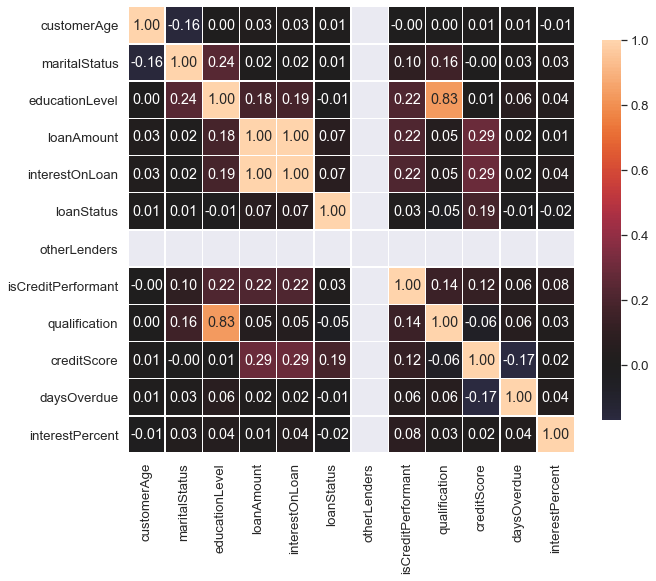

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
# spearman correlation for checking for redundancy
def correlation_heatmap(data):
	correlations = data.corr()
	sns.set(font_scale=1.2)
	fig, ax = plt.subplots(figsize=(10, 10))
	sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f',
				square=True, linewidths=.5, annot=True, cbar_kws={"shrink":.70})
	plt.show();
correlation_heatmap(model_data)

In [31]:
# drop interest on loan because spearman correlation shows its redundant
model_data = model_data.drop(columns=['interestOnLoan', 'qualification'])


In [32]:
# remove the target from the feature set
features = model_data.iloc[:, model_data.columns != 'loanStatus']

# clean the dataset of NaN and infinity
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)
model_data = pd.merge(clean_dataset(features), model_data['loanStatus'], left_index=True, right_index=True)


<ipython-input-32-38802a96381b>:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [33]:
# remove a few outliers from the histograms
model_data = model_data[model_data.customerAge < 6]
model_data = model_data[model_data.customerAge > 0]
model_data = model_data[model_data.daysOverdue < 100]
model_data = model_data[model_data.interestPercent > 2]
model_data

# split between features and labels, then create test/train sets
features = model_data.iloc[:, model_data.columns != 'loanStatus']
labels = model_data['loanStatus']

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

In [34]:
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from imblearn.over_sampling import ADASYN

# create synthetic data to fix the current 97:3 target ratio

def makeOverSamplesADASYN(X_train, y_train):
	sm = ADASYN()
	X, y = sm.fit_resample(features, labels)
	return(X,y)

X_train, y_train = makeOverSamplesADASYN(features, labels)

## Models

In [35]:
predictions = pd.DataFrame(y_test)
target_names = ['0', '1']
cfs = {}

def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:

	dfs = []
	# list the models to test
	models = [
			('LogReg', LogisticRegression()), 
			('RF', RandomForestClassifier()),
			('SVM', SVC()), 
			('GNB', GaussianNB()),
			('XGB', XGBClassifier())
			]
	results = []
	names = []
	scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']

	# run kfold cv and various eval functions on the data for each model
	for name, model in models:
		kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
		cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
		clf = model.fit(X_train, y_train)

		y_pred = clf.predict(X_test)
		predictions[name+'_pred'] = y_pred

		print(name)
		print(classification_report(y_test, y_pred, target_names=target_names))
		
		cfs[str(name)]=(confusion_matrix(y_test, y_pred))
		results.append(cv_results)
		names.append(name)
		this_df = pd.DataFrame(cv_results)
		this_df['model'] = name
		dfs.append(this_df)
		
	final = pd.concat(dfs, ignore_index=True)
	return final

final = run_exps(X_train, y_train, X_test, y_test)

/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/Users/zacharycoriarty/Library/Python/3.8/lib/python/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

LogReg
              precision    recall  f1-score   support

           0       0.14      0.84      0.23        43
           1       0.99      0.68      0.81       730

    accuracy                           0.69       773
   macro avg       0.56      0.76      0.52       773
weighted avg       0.94      0.69      0.78       773

RF
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        43
           1       1.00      1.00      1.00       730

    accuracy                           1.00       773
   macro avg       1.00      1.00      1.00       773
weighted avg       1.00      1.00      1.00       773

SVM
              precision    recall  f1-score   support

           0       0.13      0.84      0.22        43
           1       0.99      0.67      0.79       730

    accuracy                           0.68       773
   macro avg       0.56      0.75      0.51       773
weighted avg       0.94      0.68      0.76       773

GNB
 

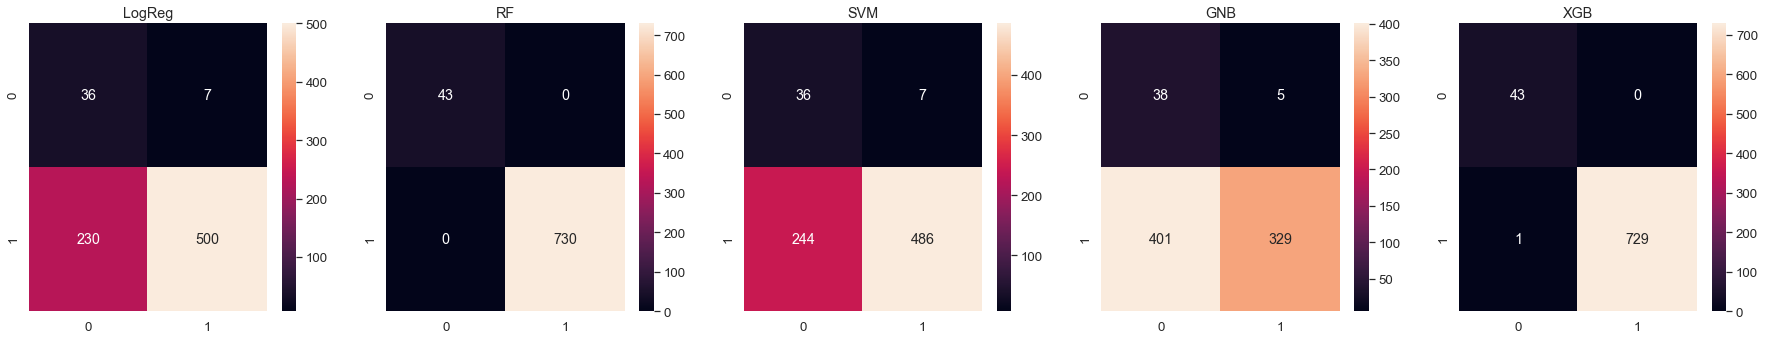

In [42]:
predictions = predictions.sort_index()
fig, axs = plt.subplots(1, 5)
fig.subplots_adjust(left=1, bottom=1, right=5, top=2, wspace=None, hspace=None)
for i, (k, v) in enumerate(cfs.items()):
	sns.heatmap(v, annot=True, fmt='g', ax=axs[i]).set_title(str(k))

## Refining the Best Model

In [36]:
from bayes_opt import BayesianOptimization
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from xgboost import XGBClassifier

# use BayesOpt to optimize the parameters in the XGBoost classifier
def xgb_classifier(n_estimators, max_depth, reg_alpha,
                   reg_lambda, min_child_weight, num_boost_round,
                   gamma):
    params = {"booster": 'gbtree',
              "objective" : "binary:logistic",
              "eval_metric" : "auc", 
              "is_unbalance": True,
              "n_estimators": int(n_estimators),
              "max_depth" : int(max_depth),
              "reg_alpha" : reg_alpha,
              "reg_lambda" : reg_lambda,
              "gamma": gamma,
              "num_threads" : 20,
              "min_child_weight" : int(min_child_weight),
              "learning_rate" : 0.01,
              "subsample_freq" : 5,
              "seed" : 42,
              "verbosity" : 0,
              "num_boost_round": int(num_boost_round)}
    train_data = xgb.DMatrix(X_train, y_train)
    cv_result = xgb.cv(params,
                       train_data,
                       1000,
                       early_stopping_rounds=100,
                       stratified=True,
                       nfold=3)
    return cv_result['test-auc-mean'].iloc[-1]

xgbBO = BayesianOptimization(xgb_classifier, {  "n_estimators": (10, 100),
                                                'max_depth': (5, 40),
                                                'reg_alpha': (0.0, 0.1),
                                                'reg_lambda': (0.0, 0.1),
                                                'min_child_weight': (1, 10),
                                                'num_boost_round': (100, 1000),
                                                "gamma": (0, 10)
                                                })

xgbBO.maximize(n_iter=15, init_points=2)

|   iter    |  target   |   gamma   | max_depth | min_ch... | n_esti... | num_bo... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
|  1        |  0.9949   |  7.238    |  27.18    |  4.474    |  88.98    |  615.5    |  0.08957  |  0.002064 |
|  2        |  0.9932   |  9.342    |  15.22    |  7.21     |  29.06    |  234.6    |  0.08384  |  0.07661  |
|  3        |  0.9946   |  7.764    |  29.47    |  4.345    |  92.48    |  613.5    |  0.07563  |  0.08289  |
|  4        |  0.994    |  8.781    |  12.28    |  5.202    |  76.96    |  618.6    |  0.04794  |  0.005252 |
|  5        |  0.9955   |  4.334    |  33.73    |  5.047    |  84.65    |  625.1    |  0.004128 |  0.01047  |
|  6        |  0.9965   |  0.7373   |  38.63    |  6.463    |  70.34    |  624.5    |  0.09436  |  0.08628  |
|  7        |  0.9946   |  4.907    |  39.08    |  7.26     |  57.62    |  633.8    |  0.08825  |  0.06115  |
|  8      

In [37]:
params = xgbBO.max['params']
print(params)
params['max_depth']= int(params['max_depth'])
params['n_estimators']= int(params['n_estimators'])

model = XGBClassifier(**params).fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_pred, y_test))

cm = confusion_matrix(y_pred, y_test)
acc = cm.diagonal().sum()/cm.sum()


{'gamma': 1.1420234507165339, 'max_depth': 36.94606341563076, 'min_child_weight': 2.804748627396359, 'n_estimators': 38.02551421627314, 'num_boost_round': 603.783419985155, 'reg_alpha': 0.04521890058642697, 'reg_lambda': 0.03524061719207438}
              precision    recall  f1-score   support

           0       0.91      0.93      0.92        42
           1       1.00      0.99      1.00       731

    accuracy                           0.99       773
   macro avg       0.95      0.96      0.96       773
weighted avg       0.99      0.99      0.99       773



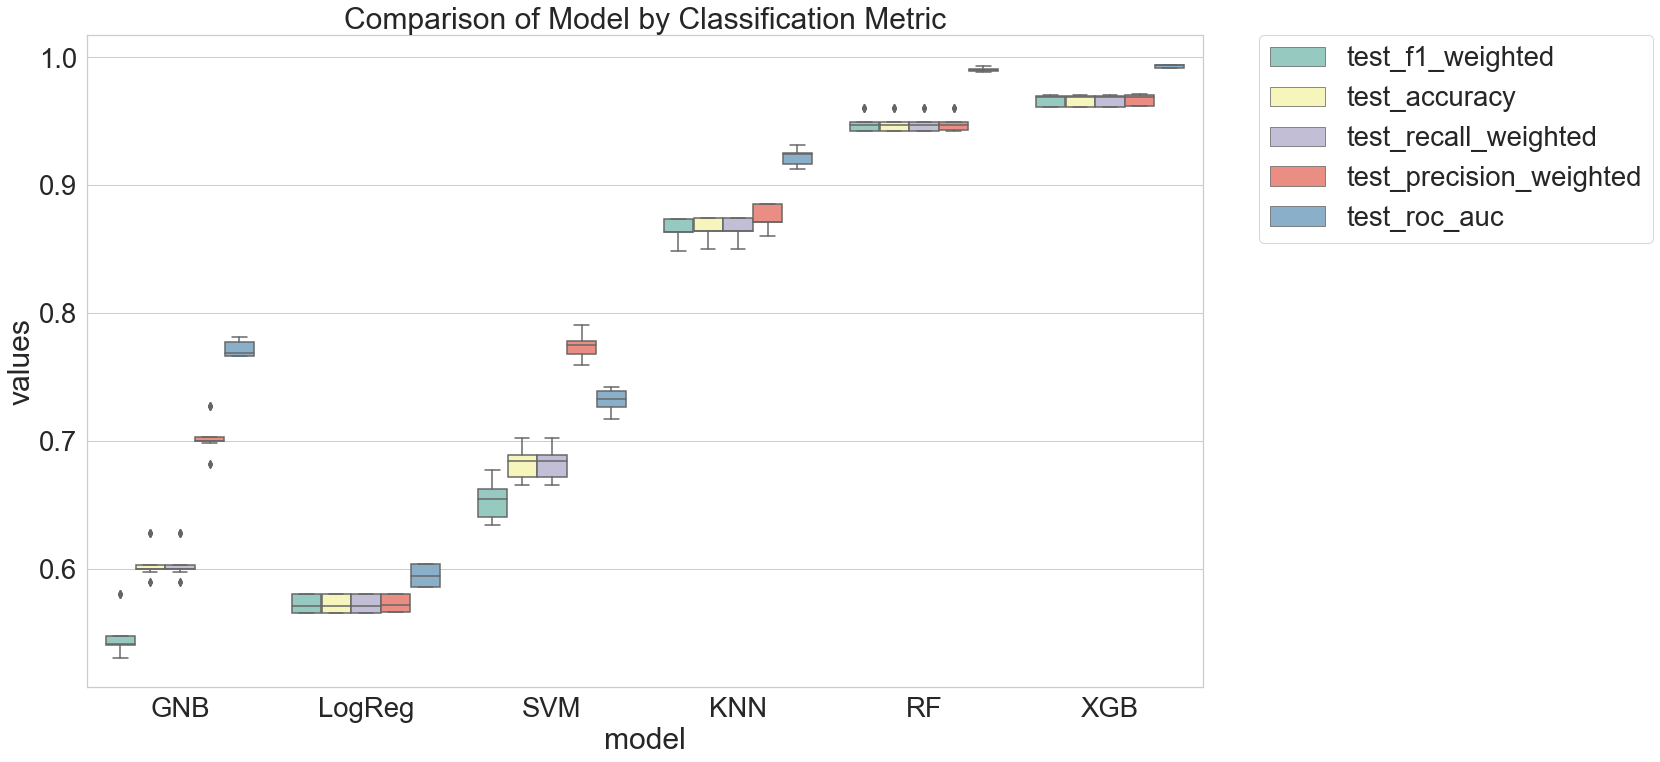

In [235]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
sns.set_style("whitegrid")
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./benchmark_models_performance.png',dpi=300)

## Distribution Analysis

In [41]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

for col in X_train.columns:
	fig = make_subplots(rows=1, cols=2)
	trace1 = go.Histogram(x=old_model_data[col])
	trace2 = go.Histogram(x=X_train[col])
	fig.append_trace(trace1, row=1, col=1)
	fig.append_trace(trace2, row=1, col=2)
	fig.update_layout(title_text=str(col))

